In [1]:
!pip install torch transformers[torch] datasets evaluate sacrebleu matplotlib tqdm tensorboard tiktoken sentencepiece pyvi laonlp

import os
import json
import shutil
import torch
import evaluate
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Dict, Tuple
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
    TrainerCallback,
    EarlyStoppingCallback
)
from tqdm.auto import tqdm
import sacrebleu
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 87.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 65.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 146.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 131.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 192.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 219.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 162.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 160.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 1.5 MB/s  0:00:05m0:00:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 6.0 MB/s  0:00:000m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 76.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 171.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 154.5 MB/s  0:0

In [2]:
# --- 1. CONFIGURATION CLASS ---
@dataclass
class ModelConfig:
    model_name: str = "google/mt5-base"  # THIS WILL CHANGE IN EACH NOTEBOOK
    output_dir: str = "/work/data/t5_output" # THIS WILL CHANGE IN EACH NOTEBOOK
    
    max_source_length: int = 128
    max_target_length: int = 128
    num_beams: int = 5
    learning_rate: float = 5e-5
    num_train_epochs: int = 4        # Set to 3 or 4 for your 700k dataset
    per_device_train_batch_size: int = 128  # Increased for H200
    per_device_eval_batch_size: int = 128
    gradient_accumulation_steps: int = 2   # Reduced to 1 for speed
    warmup_steps: int = 500
    weight_decay: float = 0.01
    logging_steps: int = 50
    eval_strategy: str = "steps"
    eval_steps: int = 1000           # Less frequent eval for speed
    save_steps: int = 1000
    save_total_limit: int = 2
    early_stopping_patience: int = 3
    fp16: bool = False
    bf16: bool = True                # H200 supports BF16
    dataloader_num_workers: int = 4
    dataloader_pin_memory: bool = True
    optim: str = "adamw_torch_fused"
    predict_with_generate: bool = True
    generation_max_length: int = 128
    generation_num_beams: int = 5

In [3]:
# --- 2. VISUALIZATION CALLBACK ---
class ProgressVisualizationCallback(TrainerCallback):
    def __init__(self, output_dir: str):
        self.output_dir = output_dir
        self.train_losses = []
        self.eval_losses = []
        self.eval_bleus = []
        self.train_steps = []
        self.eval_steps = []
        self.plots_dir = os.path.join(output_dir, "plots")
        os.makedirs(self.plots_dir, exist_ok=True)
        
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            # Track Training Loss
            if 'loss' in logs:
                self.train_losses.append(logs['loss'])
                self.train_steps.append(state.global_step)
            
            # Track Evaluation Loss & BLEU
            # (These usually appear together in logs during eval steps)
            if 'eval_loss' in logs:
                self.eval_losses.append(logs['eval_loss'])
                self.eval_steps.append(state.global_step)
            if 'eval_bleu' in logs:
                self.eval_bleus.append(logs['eval_bleu'])
    
    def on_train_end(self, args, state, control, **kwargs):
        # Create a figure with 3 side-by-side plots
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # 1. Plot Training Loss
        if self.train_losses:
            axes[0].plot(self.train_steps, self.train_losses, label='Train Loss', color='blue')
            axes[0].set_title('Training Loss')
            axes[0].set_xlabel('Steps')
            axes[0].set_ylabel('Loss')
            axes[0].legend()
            
        # 2. Plot Validation Loss
        if self.eval_losses:
            axes[1].plot(self.eval_steps, self.eval_losses, label='Val Loss', color='orange')
            axes[1].set_title('Validation Loss')
            axes[1].set_xlabel('Steps')
            axes[1].set_ylabel('Loss')
            axes[1].legend()

        # 3. Plot BLEU Score
        if self.eval_bleus:
            axes[2].plot(self.eval_steps, self.eval_bleus, label='BLEU', color='green')
            axes[2].set_title('BLEU Score')
            axes[2].set_xlabel('Steps')
            axes[2].set_ylabel('Score')
            axes[2].legend()
            
        plt.tight_layout()
        
        # Save to file
        plot_path = os.path.join(self.plots_dir, "training_metrics.png")
        plt.savefig(plot_path)
        print(f"Training finished. Plots saved to {plot_path}")
        
        # Show in Notebook
        plt.show()

In [4]:
# --- 3. DATA PREPARATOR (UPDATED WITH PYVI & LAONLP) ---
from pyvi import ViTokenizer
from laonlp.tokenize import word_tokenize

class BilingualDatasetPreparator:
    def __init__(self, tokenizer, config):
        self.tokenizer = tokenizer
        self.config = config
        
    def create_dataset_from_files(self, vi_file: str, lo_file: str) -> Dataset:
        with open(vi_file, 'r', encoding='utf-8') as f:
            # Read ALL lines
            vi_lines = f.readlines()
        with open(lo_file, 'r', encoding='utf-8') as f:
            lo_lines = f.readlines()
            
        # 1. Sanity Check
        assert len(vi_lines) == len(lo_lines), f"Raw file line counts mismatch! VI: {len(vi_lines)}, LO: {len(lo_lines)}"

        data = []
        skipped_count = 0
        
        # 2. Iterate, Segment, and Filter
        # We add tqdm here because segmentation takes more time than simple reading
        print(f"Segmenting and loading data from {vi_file} and {lo_file}...")
        for vi, lo in tqdm(zip(vi_lines, lo_lines), total=len(vi_lines), desc="Processing"):
            vi_clean = vi.strip()
            lo_clean = lo.strip()
            
            # Only keep if BOTH have content
            if vi_clean and lo_clean:
                # --- NEW TOKENIZATION LOGIC START ---
                
                # Vietnamese: PyVi (Output: "Học_sinh đi học")
                # PyVi adds underscores to compound words
                vi_segmented = ViTokenizer.tokenize(vi_clean)
                
                # Lao: LaoNLP (Output: ['ພາສາ', 'ລາວ'])
                # LaoNLP returns a list; we join with spaces for T5
                lo_tokens = word_tokenize(lo_clean)
                lo_segmented = " ".join(lo_tokens)
                
                # --- NEW TOKENIZATION LOGIC END ---

                data.append({
                    'source': f"translate Vietnamese to Laos: {vi_segmented}", 
                    'target': lo_segmented
                })
            else:
                skipped_count += 1
        
        print(f"Loaded {len(data)} pairs. Skipped {skipped_count} empty/misaligned lines.")
        return Dataset.from_list(data)

    def preprocess_function(self, examples):
        # This function remains the same, but now it processes the ALREADY SEGMENTED text
        # The T5 tokenizer will subword-tokenize the words/underscores produced above.
        model_inputs = self.tokenizer(examples['source'], max_length=self.config.max_source_length, truncation=True)
        labels = self.tokenizer(text_target=examples['target'], max_length=self.config.max_target_length, truncation=True)
        model_inputs['labels'] = labels['input_ids']
        return model_inputs

In [5]:
# --- 4. TRAINER CLASS ---
class T5NMTTrainer:
    def __init__(self, config: ModelConfig):
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Loading from: {config.model_name}")
        self.tokenizer = AutoTokenizer.from_pretrained(config.model_name)
        self.model = AutoModelForSeq2SeqLM.from_pretrained(config.model_name)
        self.model.to(self.device)
        self.chrf = evaluate.load('chrf')
        
    def prepare_data(self, dataset_dict: DatasetDict) -> DatasetDict:
        preparator = BilingualDatasetPreparator(self.tokenizer, self.config)
        return dataset_dict.map(
            preparator.preprocess_function,
            batched=True,
            batch_size=1000,
            remove_columns=dataset_dict['train'].column_names,
            num_proc=1, # Keep 1 to be safe, or try 4
        )
    
    def compute_metrics(self, eval_preds):
        preds, labels = eval_preds
        preds = np.where(preds != -100, preds, self.tokenizer.pad_token_id)
        labels = np.where(labels != -100, labels, self.tokenizer.pad_token_id)
        decoded_preds = self.tokenizer.batch_decode(preds, skip_special_tokens=True)
        decoded_labels = self.tokenizer.batch_decode(labels, skip_special_tokens=True)
        decoded_preds = [pred.strip() for pred in decoded_preds]
        decoded_labels = [label.strip() for label in decoded_labels]
        
        bleu_score = sacrebleu.corpus_bleu(decoded_preds, [decoded_labels])
        chrf_result = self.chrf.compute(predictions=decoded_preds, references=[[l] for l in decoded_labels])
        
        # --- SAMPLE TRANSLATIONS REMOVED HERE AS REQUESTED ---
        
        return {'bleu': bleu_score.score, 'chrf': chrf_result['score']}
    
    def train(self, tokenized_datasets):
        training_args = Seq2SeqTrainingArguments(
            output_dir=self.config.output_dir,
            num_train_epochs=self.config.num_train_epochs,
            per_device_train_batch_size=self.config.per_device_train_batch_size,
            per_device_eval_batch_size=self.config.per_device_eval_batch_size,
            gradient_accumulation_steps=self.config.gradient_accumulation_steps,
            learning_rate=self.config.learning_rate,
            weight_decay=self.config.weight_decay,
            warmup_steps=self.config.warmup_steps,
            fp16=self.config.fp16,
            bf16=self.config.bf16,
            logging_dir=f"{self.config.output_dir}/logs",
            logging_steps=self.config.logging_steps,
            save_strategy="steps",
            save_steps=self.config.save_steps,
            save_total_limit=self.config.save_total_limit,
            eval_strategy=self.config.eval_strategy,
            eval_steps=self.config.eval_steps,
            predict_with_generate=True,
            generation_max_length=self.config.generation_max_length,
            load_best_model_at_end=True,
            metric_for_best_model="bleu",
            greater_is_better=True,
            report_to=["tensorboard"],
            push_to_hub=False
        )
        
        data_collator = DataCollatorForSeq2Seq(self.tokenizer, model=self.model, padding=True)
        viz_callback = ProgressVisualizationCallback(self.config.output_dir)
        
        trainer = Seq2SeqTrainer(
            model=self.model,
            args=training_args,
            train_dataset=tokenized_datasets['train'],
            eval_dataset=tokenized_datasets['validation'],
            tokenizer=self.tokenizer,
            data_collator=data_collator,
            compute_metrics=self.compute_metrics,
            callbacks=[viz_callback, EarlyStoppingCallback(early_stopping_patience=self.config.early_stopping_patience)]
        )
        
        trainer.train()
        print(f"Saving final model to {self.config.output_dir}...")
        trainer.save_model(self.config.output_dir)
        return trainer

    def update_model_layers(self, strategy="none"):
        # Unfreeze all first
        for param in self.model.parameters():
            param.requires_grad = True
            
        encoder = self.model.get_encoder()
        num_layers = len(encoder.block)
        
        if strategy == "freeze_encoder":
            print(f"Freezing entire encoder...")
            for param in encoder.parameters():
                param.requires_grad = False
                
        elif strategy == "freeze_last_half_encoder":
            start_freeze = num_layers // 2 
            print(f"Freezing last half of encoder (Layers {start_freeze}-{num_layers-1})...")
            for i in range(start_freeze, num_layers):
                for param in encoder.block[i].parameters():
                    param.requires_grad = False
            for param in encoder.final_layer_norm.parameters():
                param.requires_grad = False
        else:
            print("Unfreezing all layers (Full Fine-tuning)...")

Loading from: /work/data/t5_phase1


The tokenizer you are loading from '/work/data/t5_phase1' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Segmenting and loading data from /work/data/bigdata/train/train.vi and /work/data/bigdata/train/train.lo...


Processing:   0%|          | 0/689511 [00:00<?, ?it/s]

Loaded 689511 pairs. Skipped 0 empty/misaligned lines.
Segmenting and loading data from /work/data/bigdata/dev/dev.vi and /work/data/bigdata/dev/dev.lo...


Processing:   0%|          | 0/5000 [00:00<?, ?it/s]

Loaded 5000 pairs. Skipped 0 empty/misaligned lines.


Map (num_proc=1):   0%|          | 0/689511 [00:00<?, ? examples/s]

Map (num_proc=1):   0%|          | 0/5000 [00:00<?, ? examples/s]

--- STARTING PHASE 2 ---
Freezing entire encoder...


Step,Training Loss,Validation Loss,Bleu,Chrf
1000,1.515300,1.282226,21.374828,50.445133
2000,1.472800,1.265707,21.530491,50.623704
3000,1.448600,1.251098,21.783410,50.836167
4000,1.422600,1.241544,21.968406,51.031989
5000,1.414700,1.233084,22.131502,51.159650
6000,1.420300,1.227592,22.184115,51.206522
7000,1.414200,1.224365,22.267844,51.281203
8000,1.413600,1.222022,22.309063,51.343316


[2025-12-21 13:48:50,736] WARNING sacrebleu: That's 100 lines that end in a tokenized period ('.')
[2025-12-21 13:48:50,736] WARNING sacrebleu: It looks like you forgot to detokenize your test data, which may hurt your score.
[2025-12-21 13:48:50,736] WARNING sacrebleu: If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
[2025-12-21 13:59:01,827] WARNING sacrebleu: That's 100 lines that end in a tokenized period ('.')
[2025-12-21 13:59:01,827] WARNING sacrebleu: It looks like you forgot to detokenize your test data, which may hurt your score.
[2025-12-21 13:59:01,827] WARNING sacrebleu: If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
[2025-12-21 14:09:07,943] WARNING sacrebleu: That's 100 lines that end in a tokenized period ('.')
[2025-12-21 14:09:07,943] WARNING sacrebleu: It looks like you forgot to detokenize your test data, which may hurt your score.
[2025-

There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


Training finished. Plots saved to /work/data/t5_phase2/plots/training_metrics.png


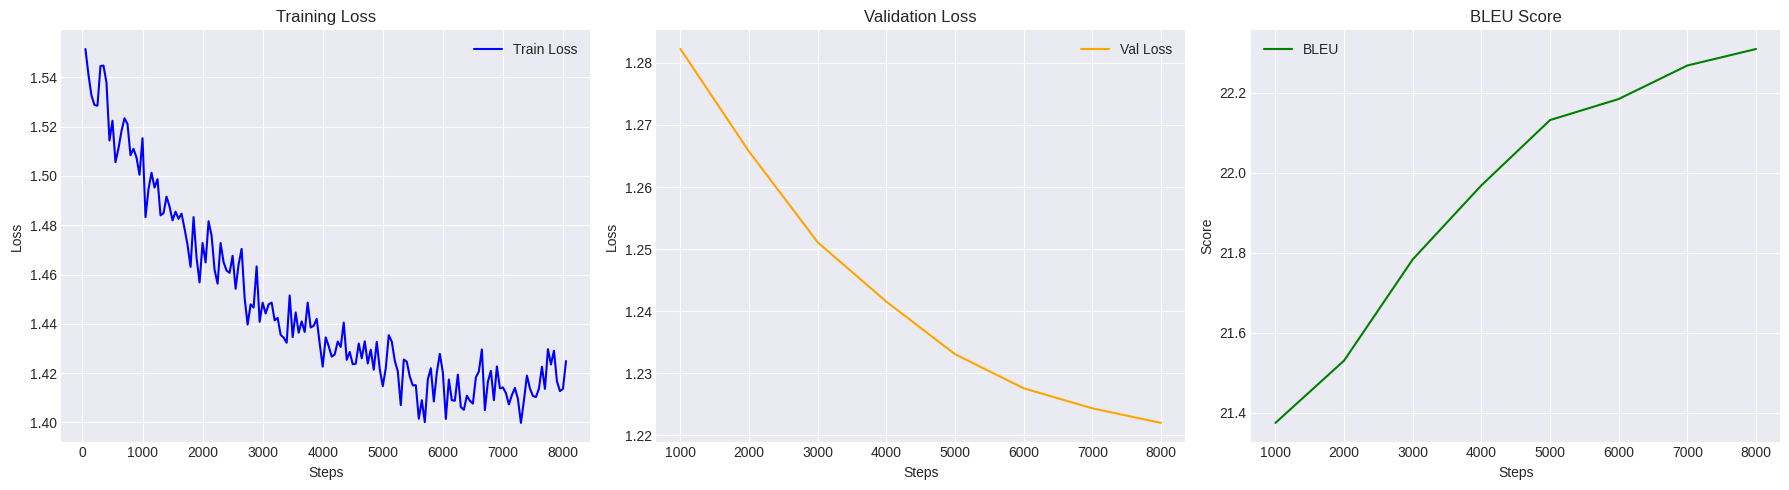

Saving final model to /work/data/t5_phase2...
PHASE 2 COMPLETE. Model saved to: /work/data/t5_phase2


In [ ]:
# --- NOTEBOOK 2 EXECUTION ---

# 1. Setup Config for Phase 2
config = ModelConfig()
config.model_name = "/work/data/t5_phase1"     # <--- LOAD FROM PHASE 1
config.output_dir = "/work/data/t5_phase2"     # <--- SAVE TO PHASE 2
config.num_train_epochs = 3                    # Typically faster phases need fewer epochs
config.learning_rate = 5e-5

# 2. Initialize
trainer_wrapper = T5NMTTrainer(config)

# 3. Load Data (Same as before)
preparator = BilingualDatasetPreparator(trainer_wrapper.tokenizer, config)
train_ds = preparator.create_dataset_from_files('/work/data/bigdata/train/train.vi', '/work/data/bigdata/train/train.lo')
val_ds = preparator.create_dataset_from_files('/work/data/bigdata/dev/dev.vi', '/work/data/bigdata/dev/dev.lo')
dataset_dict = DatasetDict({'train': train_ds, 'validation': val_ds})

# 4. Tokenize
tokenized_datasets = trainer_wrapper.prepare_data(dataset_dict)

# 5. Set Strategy & Train
print("--- STARTING PHASE 2 ---")
trainer_wrapper.update_model_layers("freeze_encoder") # <--- FREEZE STRATEGY
trainer = trainer_wrapper.train(tokenized_datasets)

print("PHASE 2 COMPLETE. Model saved to:", config.output_dir)

In [8]:
import random

def evaluate_on_test_set(trainer, test_vi_path, test_lo_path, num_samples=10):
    print(f"Loading test data from:\n  VI: {test_vi_path}\n  LO: {test_lo_path}")
    
    # 1. Load the Test Data
    # We use the global 'preparator' instance already defined in previous cells
    test_ds = preparator.create_dataset_from_files(test_vi_path, test_lo_path)
    
    # 2. Tokenize
    test_dataset_dict = DatasetDict({'test': test_ds})
    
    # --- FIX START ---
    # We call map() manually here instead of trainer_wrapper.prepare_data()
    # because prepare_data hardcodes removing columns from the 'train' split.
    tokenized_test = test_dataset_dict.map(
        preparator.preprocess_function,
        batched=True,
        batch_size=1000,
        # We explicitly ask to remove columns found in the 'test' split
        remove_columns=test_dataset_dict['test'].column_names,
        num_proc=1, 
    )
    # --- FIX END ---
    
    print("\nRunning generation on test set (this may take a moment)...")
    
    # 3. Predict (Run Inference)
    test_results = trainer.predict(tokenized_test['test'])
    
    # 4. Print Metrics
    print("FINAL TEST SET METRICS")
    print(f"BLEU: {test_results.metrics['test_bleu']:.2f}")
    print(f"chrF: {test_results.metrics['test_chrf']:.2f}")
    print(f"Loss: {test_results.metrics['test_loss']:.4f}")
    
    # 5. Show Sample Translations
    predictions = test_results.predictions
    predictions = np.where(predictions != -100, predictions, trainer.tokenizer.pad_token_id)
    
    label_ids = test_results.label_ids
    label_ids = np.where(label_ids != -100, label_ids, trainer.tokenizer.pad_token_id)
    
    decoded_preds = trainer.tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = trainer.tokenizer.batch_decode(label_ids, skip_special_tokens=True)
    # --- FIX END ---
    
    # Get original source text (decode input_ids)
    input_ids = tokenized_test['test']['input_ids']
    # Also clean input_ids just in case
    input_ids = np.where(input_ids != -100, input_ids, trainer.tokenizer.pad_token_id)
    decoded_inputs = trainer.tokenizer.batch_decode(input_ids, skip_special_tokens=True)

    print(f"--- RANDOMLY SELECTED SAMPLES ({num_samples}) ---")
    indices = random.sample(range(len(decoded_preds)), min(num_samples, len(decoded_preds)))
    
    for i in indices:
        print(f"Example #{i}:")
        print(f"Input (VI) : {decoded_inputs[i]}")
        print(f"Ref (LO)   : {decoded_labels[i]}")
        print(f"Pred (LO)  : {decoded_preds[i]}")
        print("-" * 50)

# --- CONFIGURATION FOR TEST ---
TEST_VI_PATH = '/work/data/bigdata/test/test_vi.txt' 
TEST_LO_PATH = '/work/data/bigdata/test/test_lo.txt'

# Run the evaluation
evaluate_on_test_set(trainer, TEST_VI_PATH, TEST_LO_PATH)

Loading test data from:
  VI: /work/data/bigdata/test/test_vi.txt
  LO: /work/data/bigdata/test/test_lo.txt
Segmenting and loading data from /work/data/bigdata/test/test_vi.txt and /work/data/bigdata/test/test_lo.txt...


Processing:   0%|          | 0/1000 [00:00<?, ?it/s]

Loaded 1000 pairs. Skipped 0 empty/misaligned lines.


Map (num_proc=1):   0%|          | 0/1000 [00:00<?, ? examples/s]


Running generation on test set (this may take a moment)...


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


FINAL TEST SET METRICS
BLEU: 21.96
chrF: 50.98
Loss: 1.2169
--- RANDOMLY SELECTED SAMPLES (10) ---
Example #692:
Input (VI) : translate Vietnamese to Laos: Đây là cái gì vậy ? Từ " enjoyed " là tính từ hay trạng từ ?
Ref (LO)   : ນີ້ວ່າ ແນວໃດ ? ຄໍາ ວ່າ enjoyable ເປັນ ຄຸນນະສັບ ຫຼື
Pred (LO)  : ນີ້ ແມ່ນ ຫຍັງ ? ຄໍາ ວ່າ enjoyed ແມ່ນ ຫມາຍ ຫຼື ແປວ່າ ?
--------------------------------------------------
Example #758:
Input (VI) : translate Vietnamese to Laos: Báo_cáo cho biết không có bằng_chứng nào cho thấy máy_bay chiến_đấu của Israel đã xâm_phạm không_phận Syria .
Ref (LO)   : ລາຍງານ ເວົ້າວ່າ ບໍ່ມີ ຮ່ອງຮອຍ ໃດ ໆ ສະແດງ ໃຫ້ເຫັນ ວ່າ ເຮືອບິນ ລົບ ຂອງ ອິ ສຣາ ແອ ລ ໄດ້ ບິນ ເຂົ້າໄປ ໃນ ເຂດ ນ່ານຟ້າ ຂອງ ຊີເຣຍ
Pred (LO)  : ລາຍງານ ກ່າວ ວ່າ ບໍ່ມີ ຫຼັກຖານ ໃດ ໆ ທີ່ ສະແດງ ໃຫ້ເຫັນ ວ່າ ເຮືອບິນ ລົບ ຂອງ ອິ ສຣາ ແອ ລ ໄດ້ ບຸກ ເຂົ້າໄປ ໃນ ເຂດ ນ່ານຟ້າ ຂອງ ຊີເຣຍ
--------------------------------------------------
Example #913:
Input (VI) : translate Vietnamese to Laos: Người này là một tấm gương sáng về việc sẵn_lòng tha